# IOOS GTS Statistics


The Global Telecommunication System (GTS) is a coordinated effort for rapid distribution of observations.
The GTS monthly reports show the number of messages released to GTS for each station.
The reports contain the following fields:

- location ID: Identifier that station messages are released under to the GTS;
- region: Designated IOOS Regional Association (only for IOOS regional report);
- sponsor: Organization that owns and maintains the station;
- Met: Total number of met messages released to the GTS
- Wave: Total number of wave messages released to the GTS

In this notebook we will explore the statistics of the messages IOOS is releasing to GTS.

The first step is to download the data. We will use an ERDDAP server that [hosts the CSV files](https://ferret.pmel.noaa.gov/generic/erddap/files/ioos_obs_counts/) with the ingest data.

In [1]:
from datetime import date

from erddapy import ERDDAP

server = "http://osmc.noaa.gov/erddap"
e = ERDDAP(server=server, protocol="tabledap")

e.dataset_id = "ioos_obs_counts"
e.variables = ["time", "locationID", "region", "sponsor", "met", "wave"]
e.constraints = {
    "time>=": "2019-09",
    "time<": "2020-11",
}

In [2]:
df = e.to_pandas(parse_dates=True)

df["locationID"] = df["locationID"].str.lower()

df.tail()

,time (UTC),locationID,region,sponsor,met,wave
2188,2020-09-01T00:00:00Z,41029,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1440,0
2189,2020-09-01T00:00:00Z,41037,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1434,0
2190,2020-09-01T00:00:00Z,41064,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1428,0
2191,2020-09-01T00:00:00Z,sipf1,SECOORA,FLORIDA INSTITUTE OF TECHNOLOGY,5624,0
2192,2020-09-01T00:00:00Z,42098,SECOORA,GREATER TAMPA BAY MARINE ADVISORY COUNCIL PORTS,0,2828


The table has all the ingest data from 2019-01-01 to 2020-06-01. We can now explore it grouping the data by IOOS Regional Association (RA).

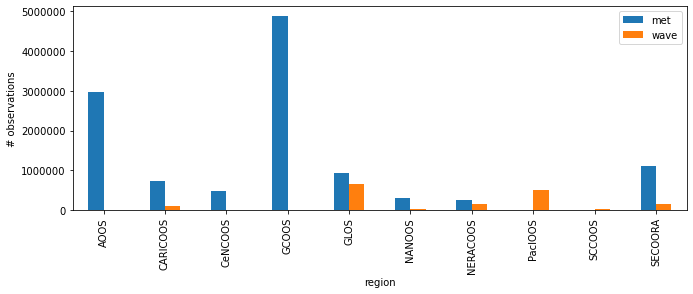

In [3]:
groups = df.groupby("region")

ax = groups.sum().plot(kind="bar", figsize=(11, 3.75))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations");

Let us check the monthly sum of data released both for individuak met and wave and the totdals.

In [4]:
import pandas as pd

df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
# Remove time-zone info for easier plotting, it is all UTC.
df["time (UTC)"] = df["time (UTC)"].dt.tz_localize(None)

groups = df.groupby(pd.Grouper(key="time (UTC)", freq="M"))

We can create a table of observations per month,

In [5]:
s = groups.sum()
totals = s.assign(total=s["met"] + s["wave"])
totals.index = totals.index.to_period("M")

totals

,met,wave,total
time (UTC),,,
2019-09,992998,204256,1197254
2019-10,1006928,185542,1192470
2019-11,877344,104654,981998
2019-12,836598,77896,914494
2020-01,803044,80102,883146
2020-02,770202,74524,844726
2020-03,869432,78372,947804
2020-04,877658,95432,973090
2020-05,887088,106754,993842


and visualize it in a bar plot.

Text(0, 0.5, '# observations')

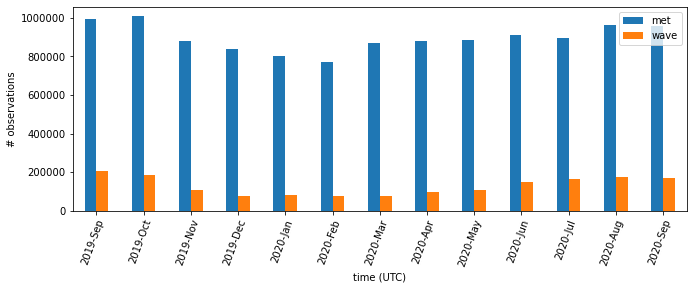

In [6]:
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 3.75))

s.plot(ax=ax, kind="bar")
ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"),
    rotation=70,
    rotation_mode="anchor",
    ha="right",
)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations")

Those plots are interesting to understand the RAs role in the GTS ingest and how much data is being released over time. It would be nice to see those per buoy on a map.

For that we need to get the position of the NDBC buoys. Let's get a table of all the buoys and match with what we have in the GTS data.

In [7]:
import xml.etree.ElementTree as et

import pandas as pd
import requests


def make_ndbc_table():
    url = "https://www.ndbc.noaa.gov/activestations.xml"
    with requests.get(url) as r:
        elems = et.fromstring(r.content)
    df = pd.DataFrame([elem.attrib for elem in list(elems)])
    df["id"] = df["id"].str.lower()
    return df.set_index("id")


buoys = make_ndbc_table()
buoys["lon"] = buoys["lon"].astype(float)
buoys["lat"] = buoys["lat"].astype(float)

buoys.head()

,lat,lon,name,owner,pgm,type,met,currents,waterquality,dart,elev,seq
id,,,,,,,,,,,,
00922,30.0,-90.0,OTN201 - 4800922,Dalhousie University,IOOS Partners,other,n,n,n,n,NaN,NaN
00923,30.0,-90.0,OTN200 - 4800923,Dalhousie University,IOOS Partners,other,n,n,n,n,NaN,NaN
01500,30.0,-90.0,SP031 - 3801500,SCRIPPS,IOOS Partners,other,n,n,n,n,NaN,NaN
01502,30.0,-90.0,Penobscot - 4801502,University of Maine,IOOS Partners,other,n,n,n,n,NaN,NaN
01503,30.0,-90.0,Saul - 4801503,Woods Hole Oceanographic Institution,IOOS Partners,other,n,n,n,n,NaN,NaN


For simplificty we will plot the total of observations per buoys.

In [8]:
groups = df.groupby("locationID")
location_sum = groups.sum()

In [9]:
buoys = buoys.T

extra_cols = pd.DataFrame({k: buoys.get(k) for k, row in location_sum.iterrows()}).T
extra_cols = extra_cols[["lat", "lon", "type", "pgm", "name"]]

map_df = pd.concat([location_sum, extra_cols], axis=1)
map_df = map_df.loc[map_df["met"] + map_df["wave"] > 0]

And now we can overlay an HTML table with the buoy information and ingest data totals.

In [10]:
from ipyleaflet import AwesomeIcon, Marker, Map, LegendControl, FullScreenControl, Popup
from ipywidgets import HTML


m = Map(center=(35, -95), zoom=4)
m.add_control(FullScreenControl())

legend = LegendControl(
    {
        "wave": "#FF0000",
        "met": "#FFA500",
        "both": "#008000"
    },
    name="GTS",
    position="bottomright",
)
m.add_control(legend)


def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return pd.DataFrame(row[["met", "wave", "type", "name", "pgm"]]).to_html(
        classes=classes
    )

for k, row in map_df.iterrows():
    if (row["met"] + row["wave"]) > 0:
        location = row["lat"], row["lon"]
        if row["met"] == 0:
            color = "red"
        elif row["wave"] == 0:
            color = "orange"
        else:
            color = "green"
        marker = Marker(
            draggable=False,
            icon=AwesomeIcon(name="life-ring", marker_color=color),
            location=location,
        )
        msg = HTML()
        msg.value = make_popup(row)
        marker.popup = msg
        m.add_layer(marker)
m

Map(center=[35, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…